In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import scipy.ndimage as nd
import math

######################################################限制GPU占用显存时使用###########################################################
using_gpu_index = 0 # 使用的 GPU 号码
gpu_list = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_list) > 0:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpu_list[using_gpu_index], 
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)
else:
    print("Got no GPUs")
###########################################################计算信息熵函数################################################################
np.set_printoptions(threshold=np.inf)
def DataEntropy(a):
    entropyVal = 0
    for i in range(len(a)):
        entropyVal = entropyVal - a[i] * math.log2((a[i]+0.000000001))
    return entropyVal

d:\PythonENV\p38tf25\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data loading


In [2]:
#未筛选养护方案

DATA_M_unselected = pd.read_excel('.\merge_M_unselected.xlsx')
print(DATA_M_unselected["处治方式"].value_counts())
DATA_M_unselected["处治方式"].replace('铣刨重铺罩面',0,inplace=True)
DATA_M_unselected["处治方式"].replace('罩面',1,inplace=True)
DATA_M_unselected["处治方式"].replace('就地热再生',2,inplace=True)
DATA_M_unselected["处治方式"].replace('超薄磨耗层',3,inplace=True)
DATA_M_unselected["处治方式"].replace('铣刨重铺',4,inplace=True)
DATA_M_unselected["处治方式"].replace('极薄磨耗层',5,inplace=True)
from sklearn.utils import shuffle
DATA_M_unselected = shuffle(DATA_M_unselected,random_state=1999)
DATA_M_unselected = shuffle(DATA_M_unselected,random_state=2005)
DATA_M_unselected = shuffle(DATA_M_unselected,random_state=2015)
DATA_M_unselected = shuffle(DATA_M_unselected,random_state=2018)
DATA_M_unselected = shuffle(DATA_M_unselected,random_state=2022)
DATA_M_unselected.reset_index(drop = True,inplace = True)
print(DATA_M_unselected['处治方式'].value_counts())

铣刨重铺      250
罩面        181
超薄磨耗层      82
铣刨重铺罩面     69
极薄磨耗层      36
就地热再生      35
Name: 处治方式, dtype: int64
4    250
1    181
3     82
0     69
5     36
2     35
Name: 处治方式, dtype: int64


In [3]:
DATA_train = DATA_M_unselected
data = DATA_train.values
data = np.array(data[:,8:15]).astype('float32')
# 4-fold cross-validation
part1 = data[:int(0.25*len(data)),:]
part2 = data[int(0.25*len(data)):int(0.5*len(data)),:]
part3 = data[int(0.5*len(data)):int(0.75*len(data)),:]
part4 = data[int(0.75*len(data)):,:]
train = np.concatenate((part2,part3,part4))
# Train set Preparation
X_train = train[:,:6]
# Label Preparation
Y_train = train[:,6]
Y_train = tf.one_hot(Y_train,6)
# Test set preparation
test = part1
X_test = test[:,:6]
Y_test = tf.one_hot(test[:,6],6)

# Evidential neural network

In [71]:
###################################################全连接不确定度量模型搭建###################################################
def Decision_model():
    inputs = tf.keras.layers.Input(shape=(6),name = 'd0')
    x1 = tf.keras.layers.Dense(units=64,activation='relu',
                               kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.2),
                               bias_initializer=keras.initializers.TruncatedNormal(stddev=0.1,mean = 0.0),name = 'd1')(inputs)
    x2 = tf.keras.layers.Dense(units=128,activation='relu',
                               kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.2,mean = 0.0),
                               bias_initializer=keras.initializers.TruncatedNormal(stddev=0.1,mean = 0.0),name = 'd2')(x1)
    x4 = tf.keras.layers.Dense(units=64,activation='relu',
                               kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.2,mean = 0.0),
                               bias_initializer=keras.initializers.TruncatedNormal(stddev=0.1,mean = 0.0),name = 'd3')(x2)
    logits = tf.keras.layers.Dense(units=6,activation=None,
                                   kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.2,mean = 0.0),
                                   bias_initializer=keras.initializers.TruncatedNormal(stddev=0.1,mean = 0.0),name = 'd4')(x4)
    evidence = tf.keras.layers.ReLU()(logits)
    alpha = evidence+1
    model_train = keras.Model(inputs = inputs, outputs = [alpha,logits,evidence],name = "rehabilitation_model_train")
    return model_train
Decision = Decision_model()
Decision.summary()

Model: "rehabilitation_model_train"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d0 (InputLayer)              [(None, 6)]               0         
_________________________________________________________________
d1 (Dense)                   (None, 64)                448       
_________________________________________________________________
d2 (Dense)                   (None, 128)               8320      
_________________________________________________________________
d3 (Dense)                   (None, 64)                8256      
_________________________________________________________________
d4 (Dense)                   (None, 6)                 390       
_________________________________________________________________
re_lu_14 (ReLU)              (None, 6)                 0         
_________________________________________________________________
tf.__operators__.add_14 (TFO (None, 6)  

# Functions used for training

In [48]:
def KL(alpha):
    beta=tf.constant(np.ones((1,6)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.math.lgamma(S_alpha) - tf.reduce_sum(tf.math.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.math.lgamma(beta),axis=1,keepdims=True) - tf.math.lgamma(S_beta)
    
    dg0 = tf.math.digamma(S_alpha)
    dg1 = tf.math.digamma(alpha)
    
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    return kl
def custom_cross_entropy_loss(y_true, alpha, L,E,epoch, batch_step, SP, n_batches): 
    S = tf.reduce_sum(alpha, axis=1, keepdims=True) 

    if epoch>=200:
        A = tf.reduce_sum(y_true * (tf.math.digamma(S) - tf.math.digamma(alpha)), axis=1, keepdims=True)
        global_step = epoch*(batch_step+1)
        annealing_step = SP*n_batches
        annealing_coef = tf.minimum(1.0, tf.cast(global_step/annealing_step,tf.float32))
        alp = E*(1-y_true) + 1 
        B =  annealing_coef * KL(alp)
        return A + B
    else:
        prob = tf.nn.softmax(L)
        cross_entropy = -tf.reduce_sum(y_true*tf.math.log(prob),axis=1, keepdims=True)
        return cross_entropy

def get_next_batch(n_batch,bsize):
    if n_batch<len(X_train) // bsize:
        return X_train[n_batch*bsize:(n_batch+1)*bsize,:],Y_train[n_batch*bsize:(n_batch+1)*bsize,:]
    else:
        return X_train[n_batch*bsize:,:],Y_train[n_batch*bsize:,:]

# Training

In [72]:
# Hyperparameter Design
bsize = 64 #batch size
n_batches = len(X_train) // bsize
optimizer = keras.optimizers.Adam(learning_rate=0.001)
epochs = 500
best_acc = 0.45
SP = 1500
# Storing training information for the training set and validation set.
train_acclist = []
train_true_ev_mean = []
train_false_ev_mean = []
test_acclist = []
test_true_ev_mean = []
test_false_ev_mean = []
path_root = "The path where you want to save the model."

import time
for epoch in range(epochs):
    #variable
    for batch_step in range(n_batches):
        X,Y = get_next_batch(batch_step,bsize)
        #tape.gradient
        with tf.GradientTape() as tape:
            A, L, E = Decision(X,training = True)
            # Average loss
            loss1 = tf.reduce_mean(custom_cross_entropy_loss(Y,A,L,E,epoch,batch_step,SP,n_batches))
            # Regularization
            loss2 = tf.nn.l2_loss(Decision.variables[6])+tf.nn.l2_loss(Decision.variables[7])
            loss = loss1+0.05*loss2
        grads = tape.gradient(loss, Decision.variables)
        grads_and_vars = zip(grads, Decision.variables)
        optimizer.apply_gradients(grads_and_vars)
        print('epoch %d - %d%%) '% (epoch+1, (100*(batch_step+1))//n_batches),end='\r' if batch_step<n_batches-1 else '')
    # Training Evaluation
    A_T, L_T, E_T = Decision.predict(X_train)
    # Predicted classes
    pred_T = tf.argmax(L_T, 1)
    # True classes
    truth_T = tf.argmax(Y_train, 1)
    # Matching the predicted values with the actual values and mapping them to 1 and 0.
    match_T = tf.reshape(tf.cast(tf.equal(pred_T, truth_T), tf.float32),(-1,1))
    # Accuracy calculation
    acc_T = tf.reduce_mean(match_T)
    # The average total evidence for a correctly classified sample.
    mean_ev_succ_T = tf.reduce_sum(tf.reduce_sum(E_T,1, keepdims=True)*match_T) / tf.reduce_sum(match_T+1e-20)
    # The average total evidence for a misclassified sample.
    mean_ev_fail_T = tf.reduce_sum(tf.reduce_sum(E_T,1, keepdims=True)*(1-match_T)) / (tf.reduce_sum(tf.abs(1-match_T))+1e-20)
    train_acclist.append(acc_T.numpy())
    train_true_ev_mean.append(mean_ev_succ_T.numpy())
    train_false_ev_mean.append(mean_ev_fail_T.numpy())
        
    # Test evaluation
    A_t, L_t, E_t = Decision.predict(X_test)
    pred_t = tf.argmax(L_t, 1)
    truth_t = tf.argmax(Y_test, 1)
    match_t = tf.reshape(tf.cast(tf.equal(pred_t, truth_t), tf.float32),(-1,1))
    acc_t = tf.reduce_mean(match_t)
    mean_ev_succ_t = tf.reduce_sum(tf.reduce_sum(E_t,1, keepdims=True)*match_t) / tf.reduce_sum(match_t+1e-20)
    mean_ev_fail_t = tf.reduce_sum(tf.reduce_sum(E_t,1, keepdims=True)*(1-match_t)) / (tf.reduce_sum(tf.abs(1-match_t))+1e-20)
    test_acclist.append(acc_t.numpy())
    test_true_ev_mean.append(mean_ev_succ_t.numpy())
    test_false_ev_mean.append(mean_ev_fail_t.numpy())
    # Uncertainty of the test set
    A_t_ALL = tf.reduce_sum(A_t,axis=1)
    uncertainty = tf.reduce_mean(6/A_t_ALL)
    
    print('training: %2.4f (%2.4f - %2.4f) \t testing: %2.4f (%2.4f - %2.4f) \t uncertainty_test:(%2.4f)' % 
          (acc_T, mean_ev_succ_T, mean_ev_fail_T, acc_t, mean_ev_succ_t, mean_ev_fail_t,uncertainty))
    if acc_t>best_acc and epoch >= 200:
        best_acc = acc_t
        save_path = path_root+'.h5'
        Decision.save(save_path)
        print('Epoch %d save the best Model, which acc_t is %2.4f'%(epoch+1,best_acc))


epoch 1 - 100%) training: 0.3837 (4.6220 - 3.9718) 	 testing: 0.3742 (4.4367 - 3.9132) 	 uncertainty_test:(0.6051)
epoch 2 - 100%) training: 0.1918 (1.9201 - 1.8811) 	 testing: 0.1534 (2.0635 - 1.8850) 	 uncertainty_test:(0.7723)
epoch 3 - 100%) training: 0.3694 (1.0877 - 0.8854) 	 testing: 0.3374 (1.1124 - 0.7539) 	 uncertainty_test:(0.8851)
epoch 4 - 100%) training: 0.2673 (0.5064 - 0.4023) 	 testing: 0.3190 (0.5151 - 0.3836) 	 uncertainty_test:(0.9427)
epoch 5 - 100%) training: 0.2224 (0.1316 - 0.1300) 	 testing: 0.2025 (0.2380 - 0.1517) 	 uncertainty_test:(0.9756)
epoch 6 - 100%) training: 0.2878 (0.0495 - 0.0792) 	 testing: 0.2822 (0.0879 - 0.1304) 	 uncertainty_test:(0.9844)
epoch 7 - 100%) training: 0.3347 (0.0830 - 0.0746) 	 testing: 0.3865 (0.0386 - 0.1084) 	 uncertainty_test:(0.9885)
epoch 8 - 100%) training: 0.3633 (0.0807 - 0.0822) 	 testing: 0.4172 (0.0444 - 0.1064) 	 uncertainty_test:(0.9886)
epoch 9 - 100%) training: 0.3755 (0.1176 - 0.0878) 	 testing: 0.3988 (0.0602 - 0

# Save the data from the training process.

In [73]:
model_Decision = tf.keras.models.load_model(save_path)
export = pd.DataFrame()
export['train_acc']=train_acclist
export['train_true_ev_mean']=train_true_ev_mean
export['train_false_ev_mean']=train_false_ev_mean
export['test_acc']=test_acclist
export['test_true_ev_mean']=test_true_ev_mean
export['test_false_ev_mean']=test_false_ev_mean
#Information Entropy on training set
A_train, L_train, E_train = model_Decision(X_train)
S = tf.reduce_sum(A_train, axis=1, keepdims=True) 
p = A_train / S
entropy_train = []
for i in range(len(p)):
    entropy_train.append(DataEntropy(p.numpy()[i]))
entropy_train = np.array(entropy_train)
entropy_train = entropy_train.reshape(-1,1)
entropy_train = pd.DataFrame(entropy_train,columns = ['entropy'])
# Uncertainty on the training set
uncertainty_train = pd.DataFrame()
A_train, L_train, E_train = model_Decision.predict(X_train)
A_train_U0 = tf.reduce_sum(A_train,axis=1)
A_train_U1 = 6/A_train_U0
uncertainty_train['uncertainty'] = A_train_U1.numpy()
# Information Entropy and Uncertainty on test set
A_test, L_test, E_test = model_Decision(X_test)
S = tf.reduce_sum(A_test, axis=1, keepdims=True) 
p = A_test / S
entropy_test = []
for i in range(len(p)):
    entropy_test.append(DataEntropy(p.numpy()[i]))
entropy_test = np.array(entropy_test)
entropy_test = entropy_test.reshape(-1,1)
entropy_test = pd.DataFrame(entropy_test,columns = ['entropy'])
uncertainty_test = pd.DataFrame()
#uncertainty
A_test, L_test, E_test = model_Decision.predict(X_test)
A_test_U0 = tf.reduce_sum(A_test,axis=1)
A_test_U1 = 6/A_test_U0
uncertainty_test['uncertainty'] = A_test_U1.numpy()
# Save data
savepath = path_root + ".xlsx"
writer = pd.ExcelWriter(savepath,engine="openpyxl")
export.to_excel(writer,"train_process",index=False)
entropy_train.to_excel(writer,"entropy_train",index=False)
entropy_test.to_excel(writer,"entropy_test",index=False)
uncertainty_train.to_excel(writer,"uncertainty_train",index=False)
uncertainty_test.to_excel(writer,"uncertainty_test",index=False)
writer.close()

# Functions for Set-Valued Decision Making

In [4]:
# Objective Function
def func(x):
  fun=0
  for i in range(len(x)):
    print(x[i])
    fun += x[i] * math.log10(x[i])
  return fun

#constraint 1: the sum of weights is 1
def cons1(x):
  return sum(x)

#constraint 2: define tolerance to imprecision
def cons2(x):
  tol = 0
  for i in range(len(x)):
    tol += (len(x) -(i+1)) * x[i] / (len(x) - 1)
  return tol
# 6 classes of maintenance plans
num_class = 6
g_result = {}  
gamma_equal_1 = np.array([1])
for j in range(2,(num_class+1)):
  num_weights = j
  ini_weights = np.asarray(np.random.rand(num_weights))

  name='weight'+str(j)
  g_result['weight'+str(j)]= np.zeros([6, j])
  # The imprecise tolerance γ increases from 0.5 to 0.9
  for i in range(6):
    if i < 5:
      tol = 0.5 + i * 0.1

      cons = ({'type': 'eq', 'fun' : lambda x: cons1(x)-1},
            {'type': 'eq', 'fun' : lambda x: cons2(x)-tol},
            {'type': 'ineq', 'fun' : lambda x: x-0.00000001}
          )
    
      res = minimize(func, ini_weights, method='SLSQP', options={'disp': True}, constraints=cons)
      g_result['weight'+str(j)][i] = res.x
    else:
      # γ==1
      gamma_equal_1 = np.concatenate([gamma_equal_1,np.array([0])])
      g_result['weight'+str(j)][i] = gamma_equal_1

#function for power set 
def PowerSetsBinary(items):  
    #generate all combination of N items  
    N = len(items)  
    #enumerate the 2**N possible combinations  
    set_all=[]
    for i in range(2**N):
        combo = []  
        for j in range(N):  
            if(i >> j ) % 2 == 1:  
                combo.append(items[j]) 
        set_all.append(combo)
    return set_all
class_set=list(range(num_class))
act_set= PowerSetsBinary(class_set)
act_set.remove(act_set[0])#emptyset is not needed
act_set=sorted(act_set)

# Utility matrix
def generate_utility_matrix(tol_i): #tol_i = 0 with tol=0.5, tol_i = 1 with tol=0.6, tol_i = 2 with tol=0.7, tol_i = 3 with tol=0.8, tol_i = 4 with tol=0.9
  utility_matrix = np.zeros([len(act_set), len(class_set)])
  for i in range(len(act_set)):
    intersec = class_set and act_set[i] 
    if len(intersec) == 1:
      utility_matrix[i, intersec] = 1 
    else:
      for j in range(len(intersec)):
        utility_matrix[i, intersec[j]] = g_result['weight'+str(len(intersec))][tol_i, 0] 
  return utility_matrix

# Benefits for set-valued decision making(Hurwicz criterion)
def benefit_for_behavior(inputs, num_class, utility_matrix, nu):
    for i in range(len(utility_matrix)):
        if i==0:
            precise = inputs[:, 0: num_class]*utility_matrix[i] 
            precise = np.sum(precise, -1, keepdims=True)
            omega_1 = inputs[:, [-1]]*np.max(utility_matrix[i])
            omega_2 = inputs[:, [-1]]*np.min(utility_matrix[i])
            omega = nu*omega_2+(1-nu)*omega_1
            benefit = precise + omega

        if i>=1:
            precise = inputs[:, 0: num_class]*utility_matrix[i] 
            precise = np.sum(precise, -1, keepdims=True)
            omega_1 = inputs[:, [-1]]*np.max(utility_matrix[i])
            omega_2 = inputs[:, [-1]]*np.min(utility_matrix[i])
            omega = nu*omega_2+(1-nu)*omega_1
            benefit_i = precise + omega
            benefit = np.concatenate([benefit, benefit_i], -1)
    return benefit

# Average utility
def average_utility(utility_matrix, inputs, labels, act_set):
  utility = 0
  cad = 0
  for i in range(len(inputs)):
    x = inputs[i]  
    y = np.argmax(labels[i])  
    utility += utility_matrix[x,y] 
    cad += len(act_set[x])
  average_utility = utility/len(inputs)
  average_cad = cad/len(inputs)
  return average_utility,average_cad

g_result


0.23932915827091428
0.9156461320258511
0.23932917317207547
0.9156461320258511
0.23932915827091428
0.9156461469270123
0.5
0.49999999999999994
0.5000000149011612
0.49999999999999994
0.5
0.5000000149011612
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.3010299956639812
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
0.23932915827091428
0.9156461320258511
0.23932917317207547
0.9156461320258511
0.23932915827091428
0.9156461469270123
0.6
0.4
0.6000000149011612
0.4
0.6
0.4000000149011612
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.29228525323862886
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
0.23932915827091428
0.9156461320258511
0.23932917317207547
0.9156461320258511
0.23932915827091428
0.9156461469270123
0.7
0.30000000000000004
0.7000000149011611
0.30000000000000004
0.7
0.30000001490116124
Optim

{'weight2': array([[0.5, 0.5],
        [0.6, 0.4],
        [0.7, 0.3],
        [0.8, 0.2],
        [0.9, 0.1],
        [1. , 0. ]]),
 'weight3': array([[0.3335011 , 0.3329978 , 0.3335011 ],
        [0.43849328, 0.32301344, 0.23849328],
        [0.55365529, 0.29268942, 0.15365529],
        [0.68187161, 0.23625679, 0.08187161],
        [0.82626492, 0.14747015, 0.02626492],
        [1.        , 0.        , 0.        ]]),
 'weight4': array([[0.25024404, 0.24940715, 0.25045359, 0.24989523],
        [0.34742931, 0.27222266, 0.21326674, 0.16708129],
        [0.46140241, 0.27557439, 0.16464399, 0.09837921],
        [0.59660136, 0.25189264, 0.10641064, 0.04509536],
        [0.7639269 , 0.18222235, 0.04377461, 0.01007615],
        [1.        , 0.        , 0.        , 0.        ]]),
 'weight5': array([[0.19995103, 0.2000632 , 0.19999785, 0.20001056, 0.19997735],
        [0.28855338, 0.23527033, 0.19174538, 0.15648471, 0.12794619],
        [0.3962901 , 0.2573464 , 0.16708259, 0.10863523, 0.0706456

# select the optimal nu.


In [57]:
# Use four-fold cross-validation to calculate the average utility on the corresponding training subsets, and then select the optimal nu.
TEST = {0:np.concatenate((part2,part3,part4)),1:np.concatenate((part1,part3,part4)),2:np.concatenate((part2,part1,part4)),3:np.concatenate((part2,part3,part1))}
value_result = {}
# Different tolerances
for j in range(6): 
    utility_j = generate_utility_matrix(j)
    value_result['gamma_'+str(j)]= np.zeros([11, 3])
    for v in np.arange(0, 11):
        mean_value = []
        # Four-fold cross-validation model
        for i in range(4):
            path_root = "The path where you save the model\The name of your model"+"th.h5"
            model_Decision = tf.keras.models.load_model(path_root)
            test = TEST[i]
            X_test = test[:,:6]
            Y_test = tf.one_hot(test[:,6],6)
            A_t,L_t,E_t = model_Decision.predict(X_test)
            num_class = 6
            omega_E_t = np.ones((len(X_test),1))*num_class
            E_t = np.array(E_t)
            singleton_omega_E_t = np.concatenate([E_t,omega_E_t],-1)
            singleton_omega_mass = singleton_omega_E_t/np.sum(singleton_omega_E_t,-1,keepdims=True)
            nu = 0.0+0.1*v
            resutls = np.argmax(benefit_for_behavior(singleton_omega_mass, num_class, utility_j, nu),-1)
            acc_num = 0
            for p in range(len(resutls)):
                act_local = resutls[p]
                set_valued_results = act_set[act_local] 

                if int(np.argmax(Y_test[p])) in set_valued_results:
                    acc_num += 1
            average_utility_imprecision,average_cad = average_utility(utility_j, resutls, Y_test, act_set)
            average_target = acc_num/(len(Y_test))
            mean_value.append([average_utility_imprecision,average_cad,average_target])
        mean_value = np.mean(mean_value,0)
        value_result['gamma_'+str(j)][v] = mean_value

# Optimal result

In [58]:
the_best_para = []
for keys,values in value_result.items():
    ave_U_index = np.argmax(values[:,0])
    ave_U = values[:,0][ave_U_index]
    the_best_para.append([ave_U_index,ave_U])
the_best_para = np.array([[9, 0.4987197946663328],
 [8, 0.499302013891842],
 [7, 0.5256484564310528],
 [5, 0.5958538498935257],
 [3, 0.7305070500390294],
 [1, 1.0]])
the_best_para

array([[9.        , 0.49871979],
       [8.        , 0.49930201],
       [7.        , 0.52564846],
       [5.        , 0.59585385],
       [3.        , 0.73050705],
       [1.        , 1.        ]])

# Graph of different nu values under various imprecise tolerance levels and the optimal nu.

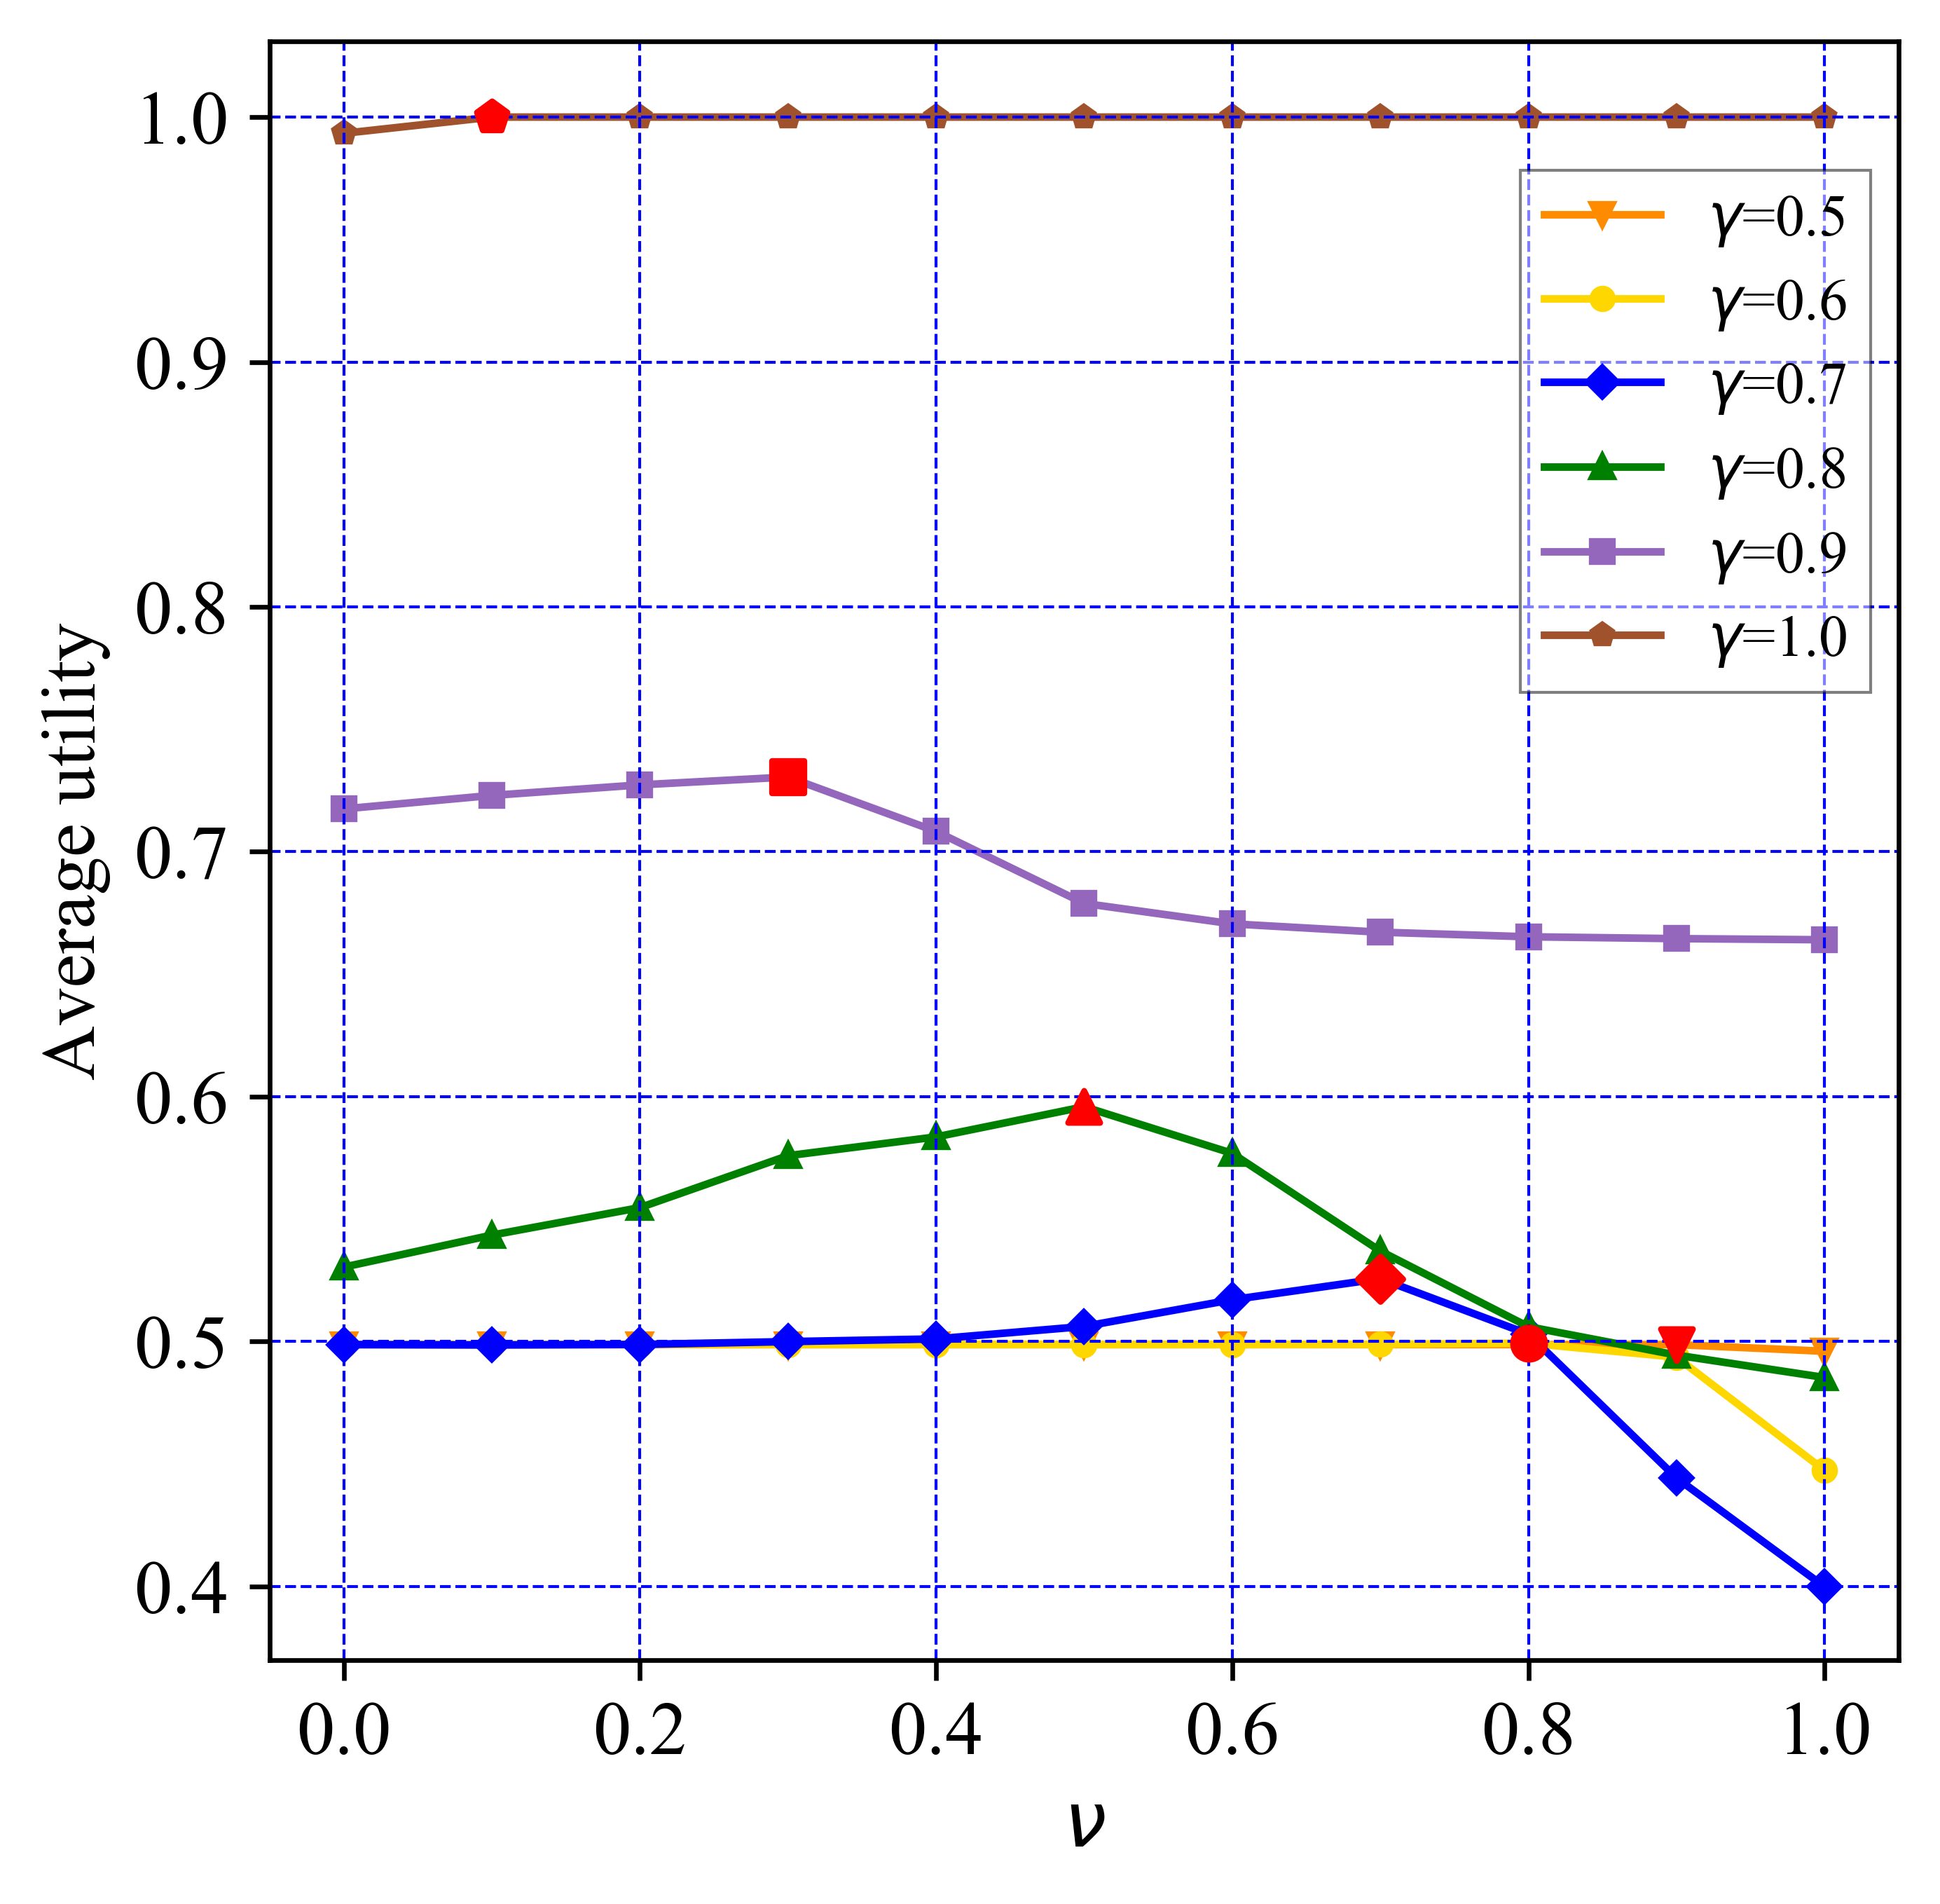

'\ngamma取1.0但是效益在nu=0的时候平均效益不为1的原因:1.mass在有的类别上是0。 2.nu取0的时候，expected_U_min=不参与比较，此时仅靠max进行比较，则由于存在mass=0的类别导致存在小集合处的max等于全集的max \n                                               3.一旦出现nu>0，则min参与比较，此时小集合处的min一定小于全集的min，则只会决策得到全集，效益全都为1了\n'

In [69]:

import matplotlib.pyplot as plt
#导入字体管理模块（主要用于中文）
from matplotlib import font_manager
from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',  
    "font.size": 13,
}
rcParams.update(config)

fig,ax = plt.subplots(1,1,figsize =(5,5),dpi = 600)

ax.set_xlabel('$\\nu$') 
ax.set_ylabel('Average utility') 
ax.grid(color=(0/255,0/255,255/255),linestyle='--',linewidth=0.5,alpha=1,zorder=0) 
shape = ['v','o','D','^','s','p']
color_i = ['darkorange','gold','b','g',(148/255,103/255,189/255),'sienna']

max_Y = []
for i in range(6):
    Y = value_result['gamma_'+str(i)][:,0]
    ax.plot(np.arange(0.0,1.1,0.1), Y, markersize='3.5',marker = shape[i],color = color_i[i],linewidth=1.3,label='$\gamma$='+str(0.5 + i*0.1),zorder=1)
for i in range(6):
    ax.scatter(the_best_para[:,0][i]*0.1,the_best_para[:,1][i],c='r',marker=shape[i],zorder=2,s=30)

plt.rcParams.update({'font.size': 10})
leg = ax.legend(bbox_to_anchor=(0.75, 0.58),fancybox = False,edgecolor = "inherit",framealpha = 0.5) 
#图例边框宽度
leg.get_frame().set_linewidth(0.5)

plt.show()


# Cardinality and error rate curve

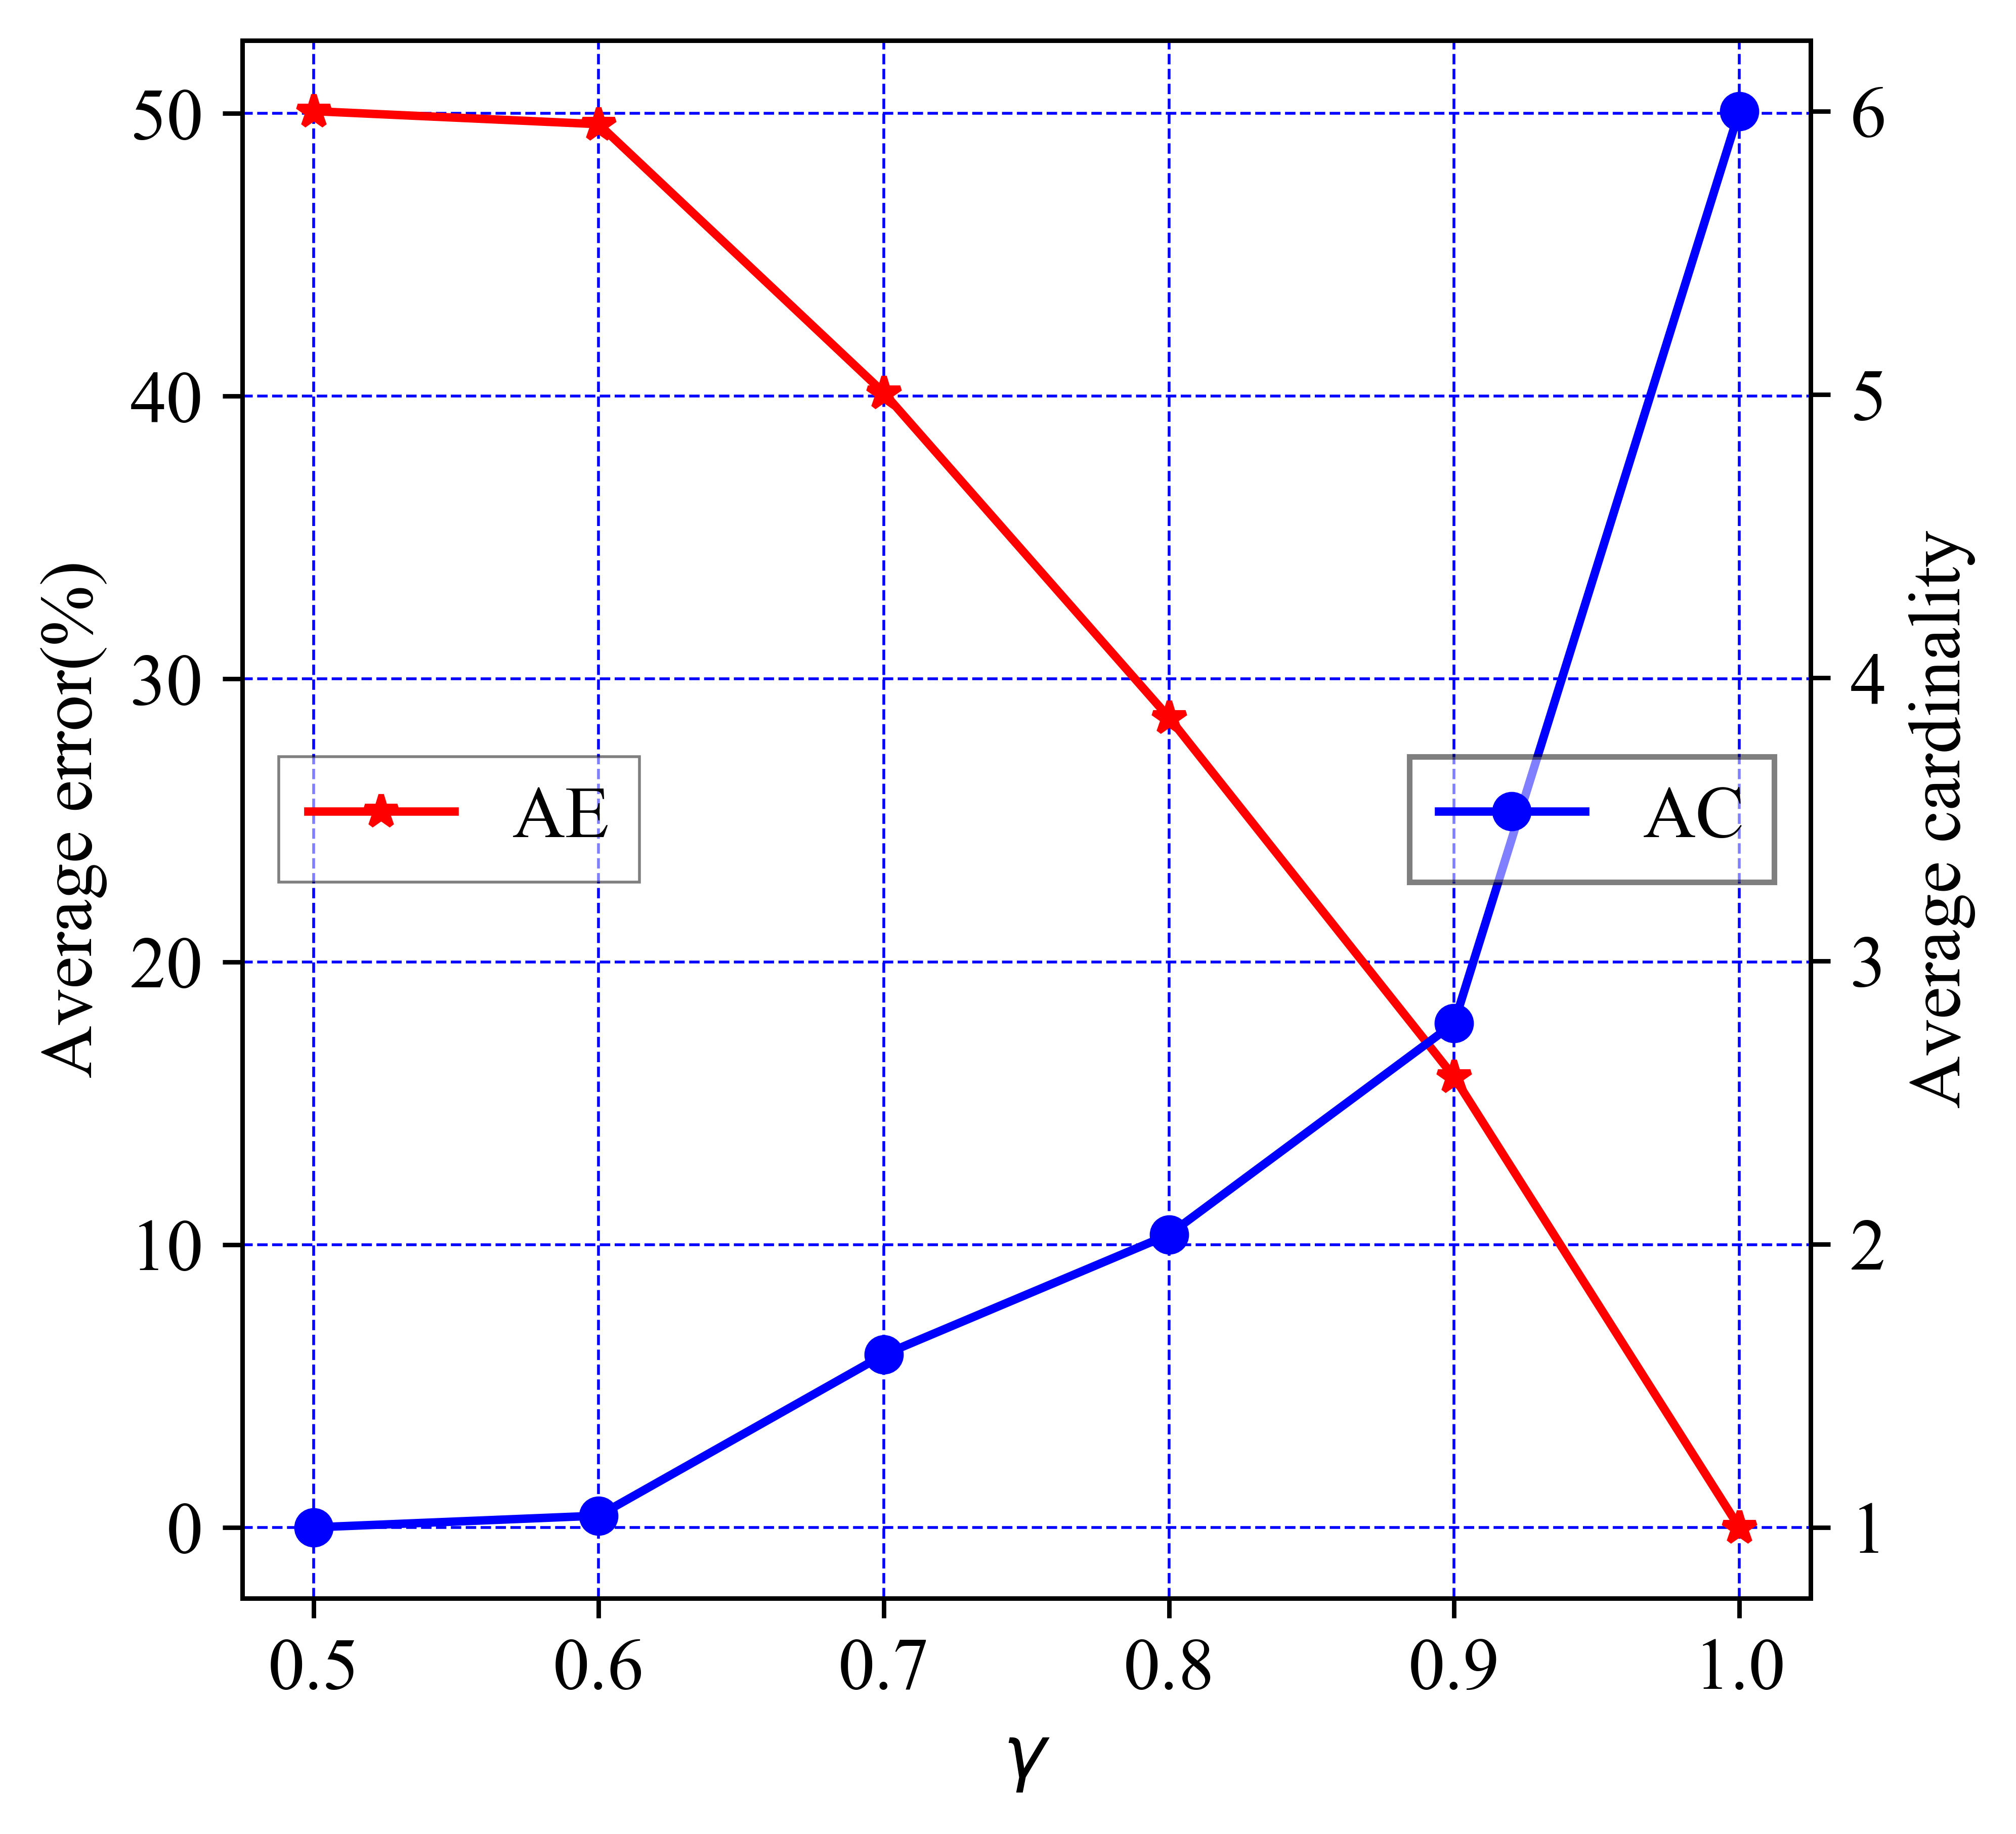

In [71]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',  
    "font.size": 13,
}
rcParams.update(config)

fig,ax = plt.subplots(1,1,figsize =(5,5),dpi = 800)
YYY1,YYY2 = [],[]
for i in range(6):
    YYY1.append(value_result['gamma_'+str(i)][int(the_best_para[:,0][i]),1]) # cad
    YYY2.append(100*(1-value_result['gamma_'+str(i)][int(the_best_para[:,0][i]),2])) # error

ax.set_xlabel('$\gamma$') 
ax.set_ylabel('Average error(%)') 
ax.grid(color=(0/255,0/255,255/255),linestyle='--',linewidth=0.5,alpha=1,zorder=0) 

ax.plot([0.5,0.6,0.7,0.8,0.9,1.0], YYY2, label = 'AE',c = 'r',marker = '*')
ax2 = ax.twinx()  
ax2.plot([0.5,0.6,0.7,0.8,0.9,1.0], YYY1, label = 'AC',c = 'b',marker = 'o')
ax2.set_ylabel('Average cardinality')
leg = ax.legend(loc='center left',fancybox = False,edgecolor = "inherit",framealpha = 0.5) 
leg2 = ax2.legend(loc='center right',fancybox = False,edgecolor = "inherit",framealpha = 0.5) 
leg.get_frame().set_linewidth(0.5)

plt.show()


# Optimal nu results under the Bayesian framework

In [9]:
prob = np.array([[ 1.        , 0.46625767],
[1.33128834, 0.61349693],
[1.83435583, 0.6993865 ],
[2.37423313, 0.82208589],
[3.06134969, 0.90797546],
[6., 1.]])

# Cardinality and error rate curve
# DST v.s. BT

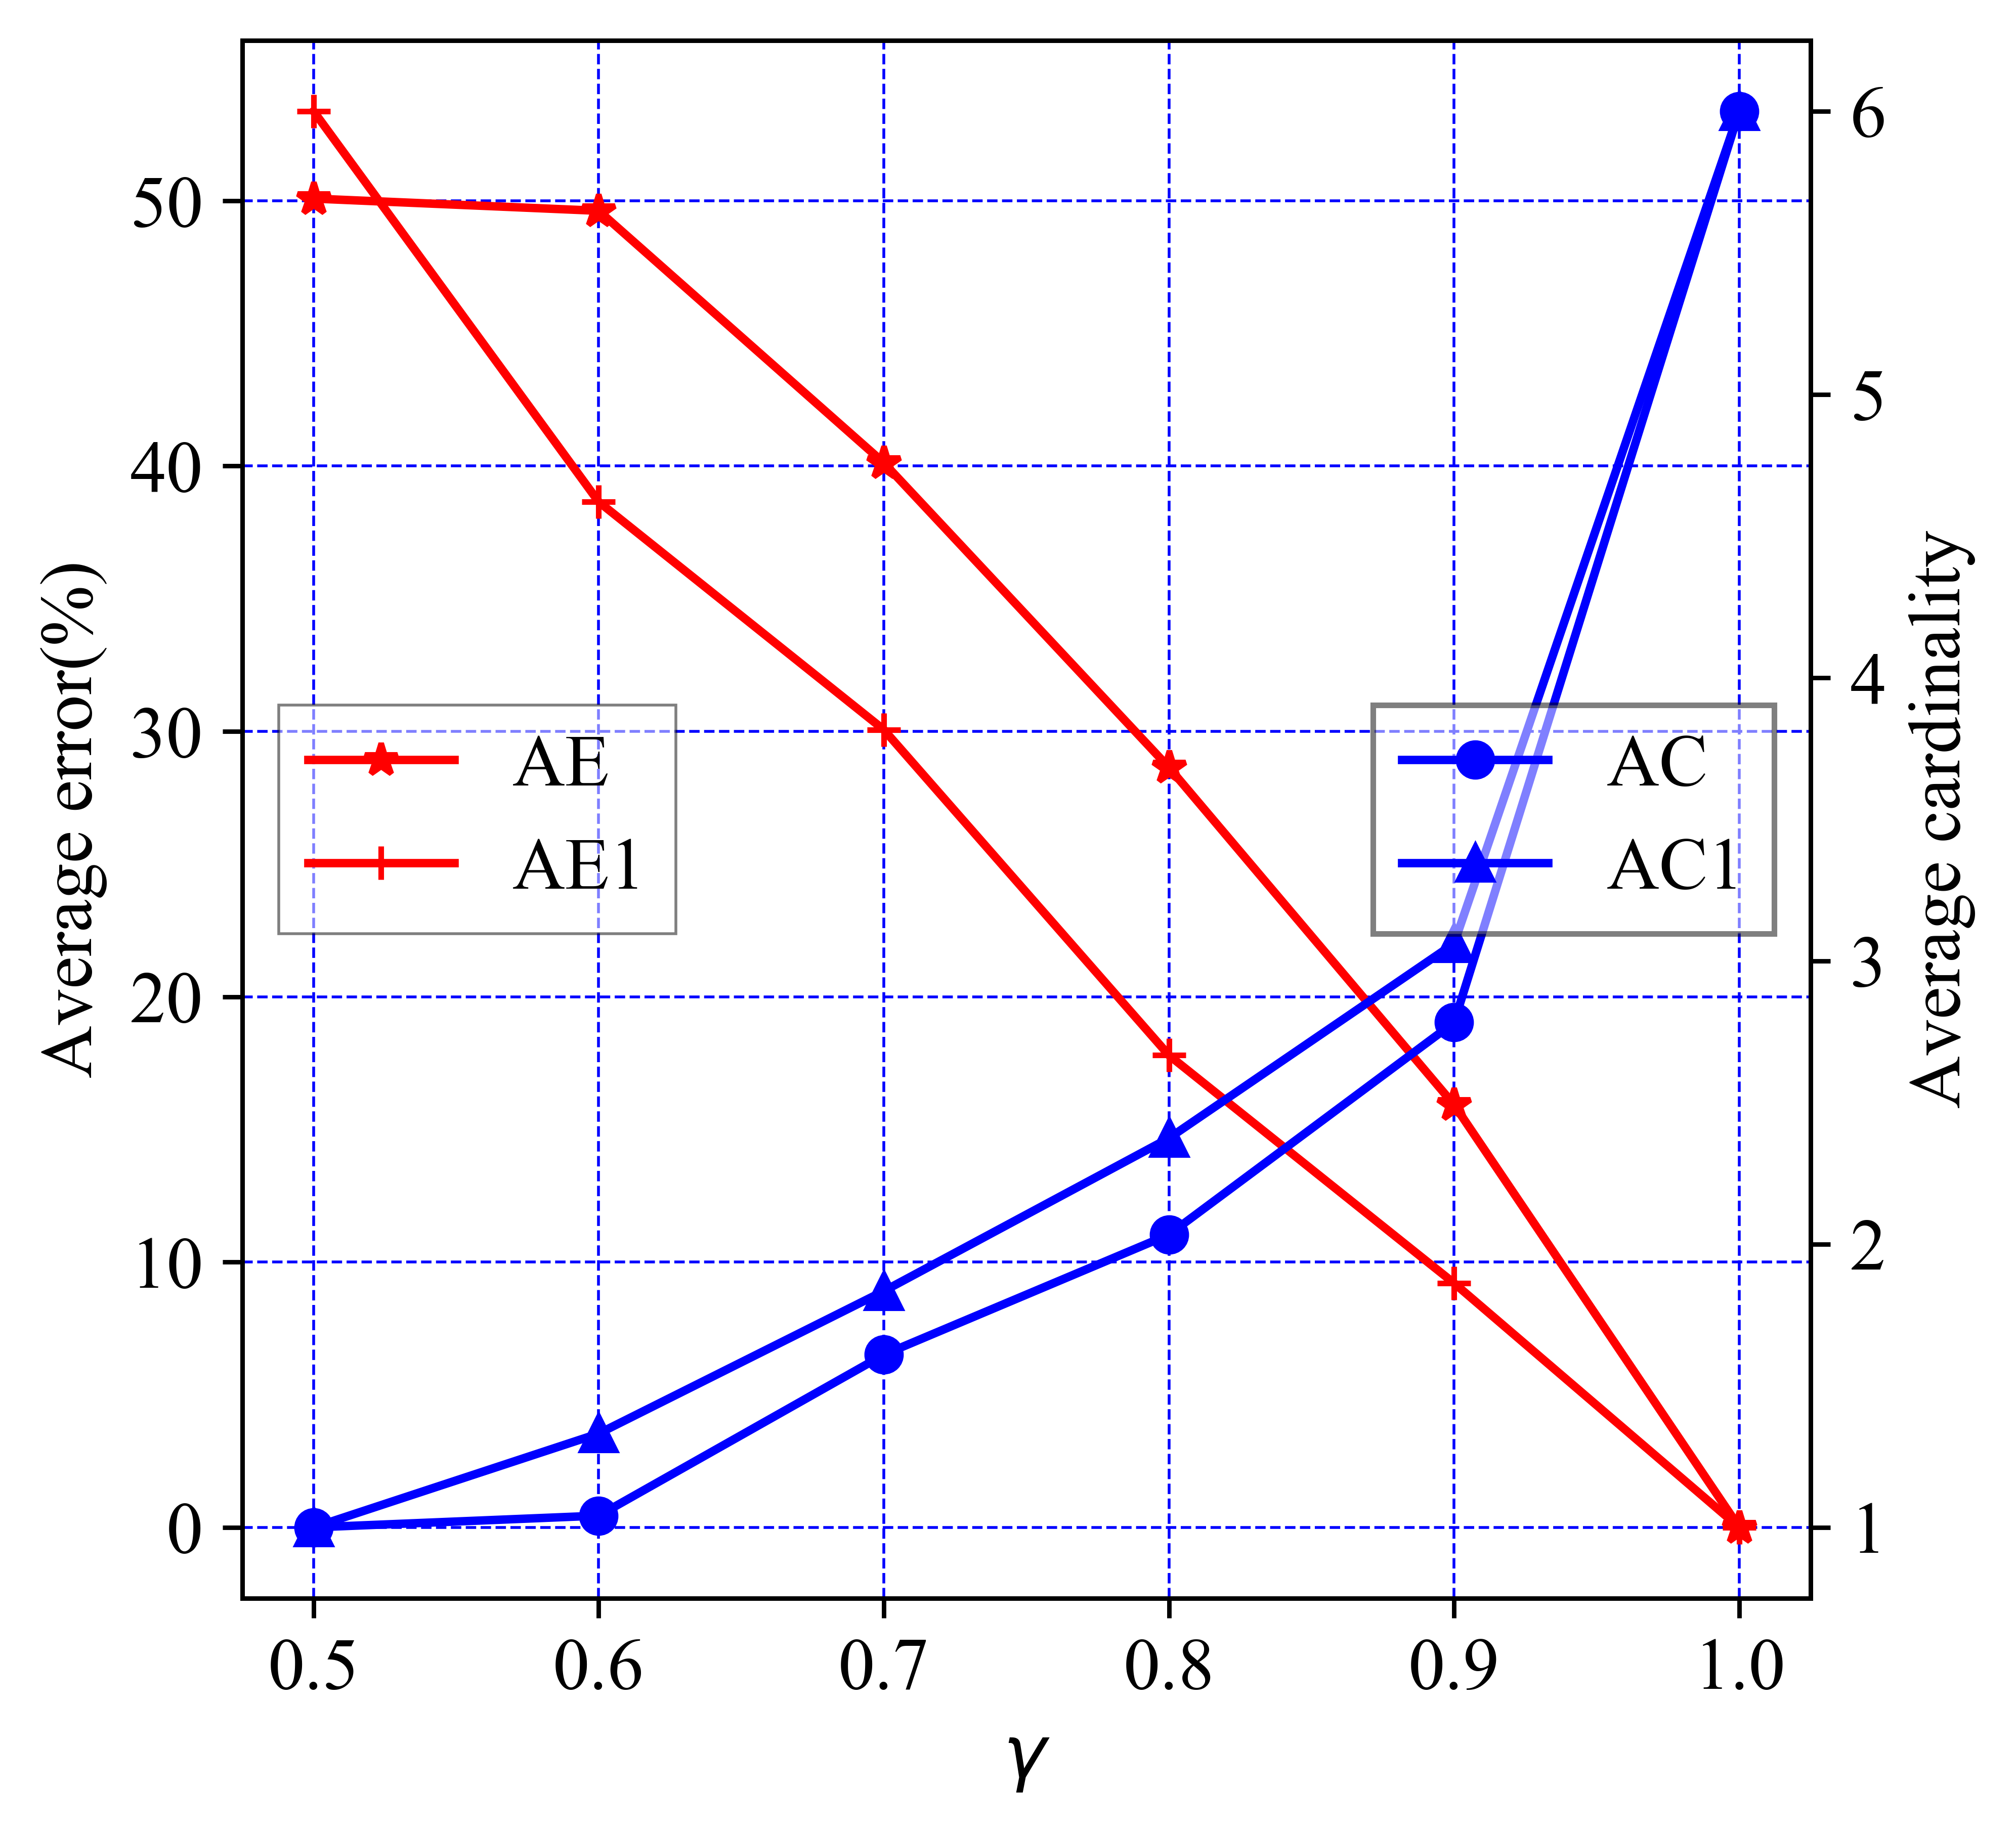

In [11]:
import matplotlib.pyplot as plt
#导入字体管理模块（主要用于中文）
from matplotlib import font_manager
from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',  
    "font.size": 13,
}
rcParams.update(config)

fig,ax = plt.subplots(1,1,figsize =(5,5),dpi = 800)
YYY1,YYY2,YYY3,YYY4 = [],[],[],[]
for i in range(6):
    YYY1.append(value_result['gamma_'+str(i)][int(the_best_para[:,0][i]),1]) # cad
    YYY2.append(100*(1-value_result['gamma_'+str(i)][int(the_best_para[:,0][i]),2])) # error
    YYY3.append(prob[i][0]) # cad
    YYY4.append(100*(1-prob[i][1])) # error

ax.set_xlabel('$\gamma$') 
ax.set_ylabel('Average error(%)') 
ax.grid(color=(0/255,0/255,255/255),linestyle='--',linewidth=0.5,alpha=1,zorder=0) 

ax.plot([0.5,0.6,0.7,0.8,0.9,1.0], YYY2, label = 'AE',c = 'r',marker = '*')
ax.plot([0.5,0.6,0.7,0.8,0.9,1.0], YYY4, label = 'AE1',c = 'r',marker = '+')
ax2 = ax.twinx()  # this is the important function
ax2.plot([0.5,0.6,0.7,0.8,0.9,1.0], YYY1, label = 'AC',c = 'b',marker = 'o')
ax2.plot([0.5,0.6,0.7,0.8,0.9,1.0], YYY3, label = 'AC1',c = 'b',marker = '^')
ax2.set_ylabel('Average cardinality')
leg = ax.legend(loc='center left',fancybox = False,edgecolor = "inherit",framealpha = 0.5) 
leg2 = ax2.legend(loc='center right',fancybox = False,edgecolor = "inherit",framealpha = 0.5) 
leg.get_frame().set_linewidth(0.5)

plt.show()


# Cardinality and Utility Curve

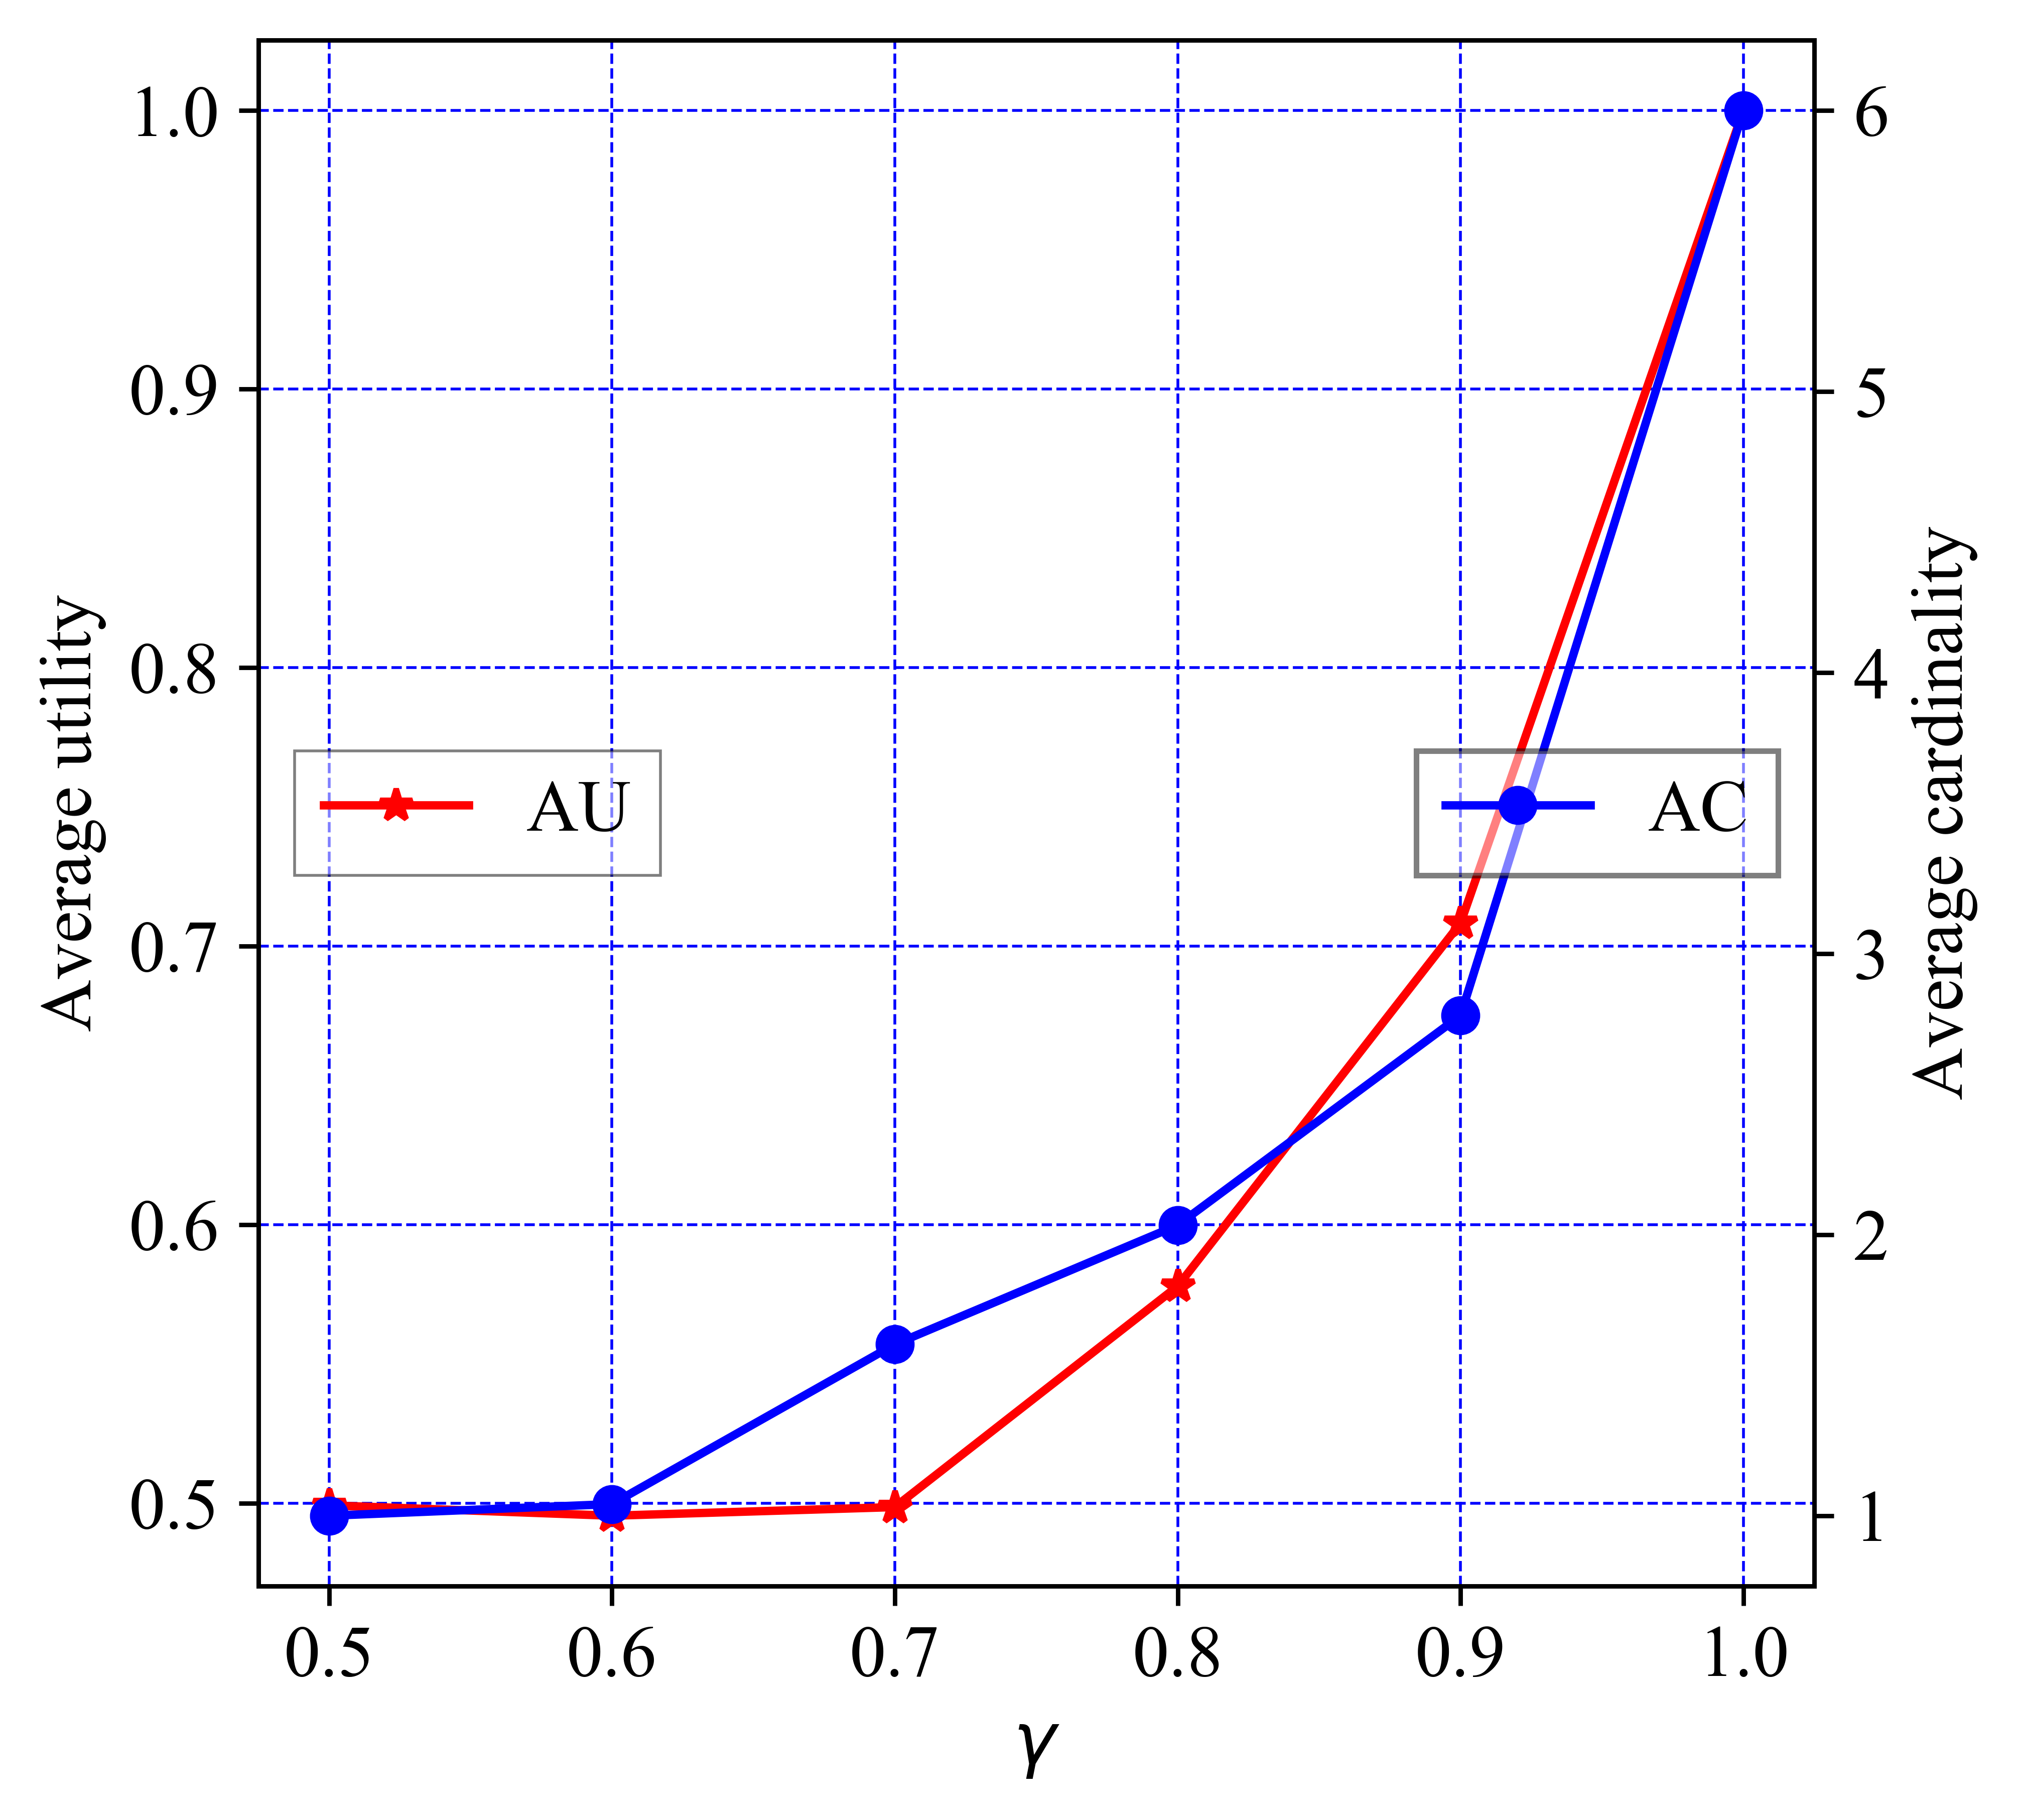

In [72]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',  
    "font.size": 13,
}
rcParams.update(config)

fig,ax = plt.subplots(1,1,figsize =(5,5),dpi = 800)
YYY1,YYY2 = [],[]
for i in range(6):
    YYY1.append(value_result['gamma_'+str(i)][int(the_best_para[:,0][i]),1]) # cad
    YYY2.append(value_result['gamma_'+str(i)][int(the_best_para[:,0][i]),0]) # error

ax.set_xlabel('$\gamma$') 
ax.set_ylabel('Average utility') 
ax.grid(color=(0/255,0/255,255/255),linestyle='--',linewidth=0.5,alpha=1,zorder=0) 

ax.plot([0.5,0.6,0.7,0.8,0.9,1.0], YYY2, label = 'AU',c = 'r',marker = '*')
ax2 = ax.twinx()
ax2.plot([0.5,0.6,0.7,0.8,0.9,1.0], YYY1, label = 'AC',c = 'b',marker = 'o')
ax2.set_ylabel('Average cardinality')
leg = ax.legend( loc='center left',fancybox = False,edgecolor = "inherit",framealpha = 0.5) 
leg2 = ax2.legend( loc='center right',fancybox = False,edgecolor = "inherit",framealpha = 0.5) 
leg.get_frame().set_linewidth(0.5)

plt.show()
